In [1]:
from collections import defaultdict
from importlib import reload
from itertools import product
from pathlib import Path
from time import perf_counter

import sys
sys.path.append("../src")
import convex
import frank_wolfe
import main_gaussian
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm



[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [327]:
data = utils.get_data(
    dataset="gaussian",
    num_buyer=30,
    num_seller=1000,
    num_val=5,
    dim=10,
    noise_level=0.1,
)

x_s = data["X_sell"].astype(np.single)
y_s = data["y_sell"]
x_val = data["X_val"].astype(np.single)
y_val = data["y_val"]
x_b = data["X_buy"].astype(np.single)
coef = data.get("coef")
y_b = (data["X_buy"] @ coef) if coef is not None else data["y_buy"]

In [335]:
x_s.shape, x_b.shape

((1000, 10), (30, 10))

In [ ]:
rang = list(range(2, 20, 1)) + list(range(20, 150, 5))

errors = defaultdict(list)
runtimes = defaultdict(list)

for j in range(0, x_b.shape[0]):
    x_test = x_b[j : j + 1]
    y_test = y_b[j : j + 1]

    res_fw = main_gaussian.design_selection(
        (x_s, y_s),
        (x_test, y_test),
        num_select=10,
        num_iters=500,
        alpha=0.1,
        recompute_interval=0,
        line_search=True,
    )
    w_fw = res_fw["weights"]
    w_os = frank_wolfe.one_step(x_s, x_test)
    errors['Ours (multi-step)'].append([utils.get_error(x_test, y_test, x_s, y_s, w_fw, k) for k in rang])
    errors['Ours (single step)'].append([utils.get_error(x_test, y_test, x_s, y_s, w_os, k) for k in rang])


    w_baselines = main_gaussian.get_baseline_values(
        x_s, y_s, x_val, y_val, np.ones_like(x_val), np.ones_like(y_val), 
        baselines=[
            'DataShapley',
            # 'DataBanzhaf',
            # 'BetaShapley',
            'LeaveOneOut',
            "DataOob",
            'KNNShapley',
            'LavaEvaluator',
            # 'RandomEvaluator',
            'DVRL',
            'InfluenceSubsample',
        ],
        baseline_kwargs={
            'DataShapley': {'mc_epochs': 100, 'models_per_iteration': 10},
            # 'DataBanzhaf': {'mc_epochs': 100, 'models_per_iteration': 10},
            # 'BetaShapley': {'mc_epochs': 100, 'models_per_iteration': 10},
            'DataOob': {'num_models': 100},
            'KNNShapley': {},
            'LavaEvaluator': {},
            'DVRL': {'rl_epochs': 100},
            'InfluenceSubsample': {'num_models': 100},
            'LeaveOneOut': {},
        },

    )
    values, times = w_baselines 

    for k, v in values.items():
        errors[k].append([utils.get_error(x_test, y_test, x_s, y_s, v, k) for k in rang])

    w_rand = np.random.permutation(len(x_s))
    errors['Random'].append([utils.get_error(x_test, y_test, x_s, y_s, w_rand, k) for k in rang])
    
    for k, v in times.items():
        runtimes[k].append(v)
    
    print(f'round {j} done')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 566.38it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.58s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.47s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.42s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.41s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.47s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.46s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.41s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.42s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.81s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.96s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.54s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.83s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.43s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1068
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.08it/s]


	TIME: 20
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.42it/s]


	TIME: 3
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 6981.70it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.53it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.18it/s]


	TIME: 1
round 0 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 355.52it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.73s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.61s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.61s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.64s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.91s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.96s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.53s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.71s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.37s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.90s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.90s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.37s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1235
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.91it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.07it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9106.38it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 117.29it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 102.16it/s]


	TIME: 1
round 1 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 433.04it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.52s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.51s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.54s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.50s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.54s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.49s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.43s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.45s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.44s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.41s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.40s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.57s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1329
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.18it/s]


	TIME: 20
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.38it/s]


	TIME: 3
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 7009.10it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 110.58it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.38it/s]


	TIME: 1
round 2 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 213.58it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.66s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.57s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.79s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.70s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1313
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.69it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.78it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 8469.11it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.09it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.07it/s]


	TIME: 1
round 3 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 257.19it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.63s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.17s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.47s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.39s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.17s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1018
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.78it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.42it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9170.68it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 117.68it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.61it/s]


	TIME: 1
round 4 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 494.68it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.20s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.36s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.57s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.21s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1020
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.21it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.41it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9299.18it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 127.27it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 99.55it/s]


	TIME: 1
round 5 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 427.73it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.86s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.69s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.34s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.38s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.20s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.34s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.49s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.75s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.50s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.46s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.21s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1065
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.25it/s]


	TIME: 18
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.78it/s]


	TIME: 3
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 7071.66it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.75it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 94.04it/s]


	TIME: 1
round 6 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 489.32it/s]


--------------DataShapley---------------
	TIME: 0
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.70it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.91it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9446.18it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.06it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.29it/s]


	TIME: 1
round 7 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 353.86it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.56s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.58s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.98s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.67s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.35s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.22s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.36s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.19s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1132
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.55it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.33it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9412.06it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 129.38it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 103.09it/s]


	TIME: 1
round 8 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 492.09it/s]


--------------DataShapley---------------
	TIME: 0
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.06it/s]


	TIME: 16
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.27it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9238.53it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.96it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 102.28it/s]


	TIME: 1
round 9 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 483.63it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.33s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.57s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.27s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.30s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.29s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.40s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.50s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.88s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.52s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.71s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.39s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1074
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.41it/s]


	TIME: 15
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.71it/s]


	TIME: 2
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 9473.78it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.26it/s]


	TIME: 1
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 99.72it/s]


	TIME: 1
round 10 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 402.46it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.09s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:04<00:00, 12.47s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.80s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.24s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.42s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.35s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.53s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.39s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.32s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.52s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.70s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 1345
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.09it/s]


	TIME: 34
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.95it/s]


	TIME: 6
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 3870.18it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 2
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.17it/s]


	TIME: 28
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.38it/s]


	TIME: 2
round 11 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.96it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.41s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:52<00:00, 17.23s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:49<00:00, 16.96s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.86s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.88s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.73s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:52<00:00, 17.28s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.42s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.58s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:26<00:00, 20.67s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:17<00:00, 19.70s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.48s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.47s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.13s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 2608
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.88it/s]


	TIME: 48
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.75it/s]


	TIME: 5
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 2001.83it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


	TIME: 31
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


	TIME: 4
round 12 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 133.25it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:32<00:00, 21.22s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.95s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.36s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:40<00:00, 22.01s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:47<00:00, 22.71s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:41<00:00, 22.15s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:38<00:00, 21.85s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:32<00:00, 21.20s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.10s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.09s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:32<00:00, 21.26s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.46s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.23s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.48s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 2981
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.73it/s]


	TIME: 36
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.52it/s]


	TIME: 5
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 2530.63it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 2
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.60it/s]


	TIME: 22
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.40it/s]


	TIME: 2
round 13 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.88it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.52s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:53<00:00, 23.33s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.11s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.52s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:49<00:00, 16.95s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:37<00:00, 15.71s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.21s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:27<00:00, 14.74s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:26<00:00, 14.70s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.43s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.25s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:55<00:00, 23.54s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:41<00:00, 22.20s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.08s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 2753
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.56it/s]


	TIME: 46
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.16it/s]


	TIME: 8
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 3519.48it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 3
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.79it/s]


	TIME: 41
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.45it/s]


	TIME: 6
round 14 done


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.42it/s]


--------------DataShapley---------------
Start: marginal contribution computation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:43<00:00, 22.38s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:41<00:00, 22.13s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:36<00:00, 21.68s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:37<00:00, 21.79s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.21s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:40<00:00, 22.09s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:44<00:00, 22.45s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:05<00:00, 18.51s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.81s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.67s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.90s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.57s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.88s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:24<00:00, 14.47s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 2556
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.57it/s]


	TIME: 27
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.48it/s]


	TIME: 5
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 8074.14it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 3
------------------DVRL------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.49it/s]


	TIME: 4
-----------InfluenceSubsample-----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.79it/s]


	TIME: 2
round 15 done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.72it/s]

--------------DataShapley---------------
Start: marginal contribution computation



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.87s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.64s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.49s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:31<00:00, 15.12s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.64s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.48s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.54s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.74s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.70s/it]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.59s/it]


gr_stat=1.0703992335806236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:44<00:00, 16.47s/it]


gr_stat=1.0960249404593188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.98s/it]


gr_stat=1.0595745209286451


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.10s/it]


gr_stat=1.0575451381501069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.44s/it]

gr_stat=1.0431981063836666
Done: marginal contribution computation


	TIME: 2228
--------------LeaveOneOut---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.62it/s]


	TIME: 35
----------------DataOob-----------------


  8%|███████████▌                                                                                                                                     | 8/100 [00:01<00:13,  7.02it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [332]:
figure_dir = Path('../figures')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


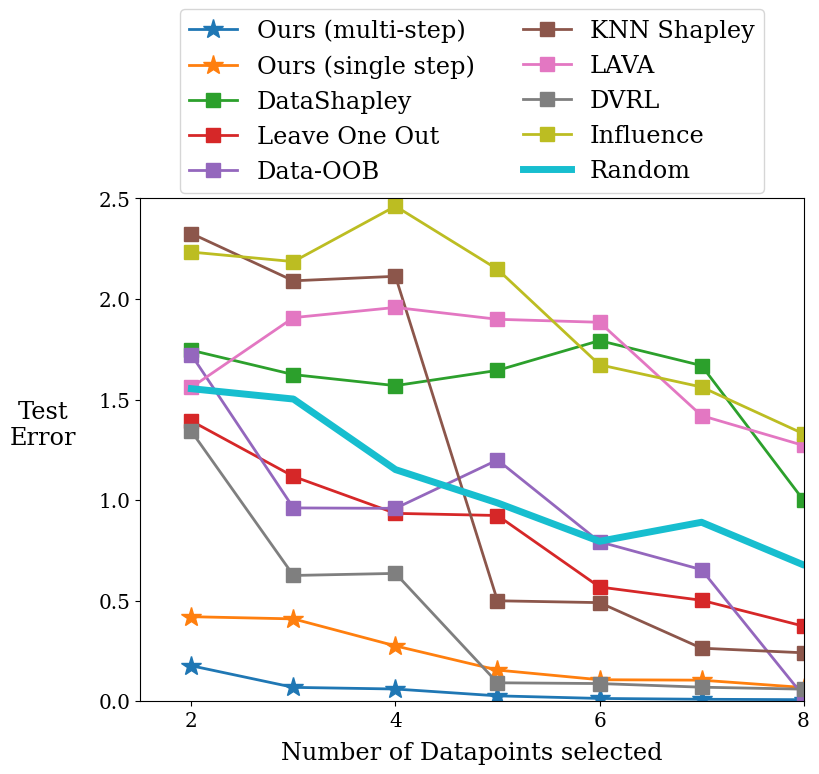

In [342]:
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(8, 8))
for k, v in errors.items():
    err = np.array(v).mean(0).squeeze()
    ms = 10
    match k:
        case 'LavaEvaluator':
            k = 'LAVA'
        case 'InfluenceSubsample':
            k = 'Influence'
        case 'LeaveOneOut':
            k = 'Leave One Out'
        case 'KNNShapley':
            k = 'KNN Shapley'
        case 'DataOob':
            k = 'Data-OOB'
    match k:
        case k if 'Ours' in k:
            lw = 2
            ls = '-'
            marker = '*'
            ms = ms + 5
        case k if 'random' in k.lower():
            lw = 5
            ls = '-'
            marker = ''
        case _:
            lw = 2
            ls = '-'
            marker = 's'
    plt.plot(rang, err, label=k, marker=marker, ls=ls, lw=lw, ms=ms)
plt.xticks(np.arange(2, 21, 2), fontsize='x-large')
plt.yticks(np.arange(0, 10, 0.5), fontsize='x-large')
# plt.xlim(1.5, 21)
# plt.ylim(0, 2.8)
    
plt.xlim(1.5, 8)
plt.ylim(0, 2.5)
# plt.ylim(0, 1.3)
# plt.ylim(0, 0.3)
plt.xlabel('Number of Datapoints selected', fontsize='xx-large', labelpad=8)
plt.ylabel('Test\nError', fontsize='xx-large', rotation=0, labelpad=40)
plt.legend(fontsize='xx-large', bbox_to_anchor=(0.5, 1.4), loc='upper center', ncols=2)
# plt.legend(fontsize='x-large', loc='upper right')
plt.tight_layout(pad=0, w_pad=0)
plt.savefig(figure_dir / f"overfitting-low-val.eps", bbox_inches="tight")